<a href="https://colab.research.google.com/github/c-labropoulos/NN-for-lithological-segmentation/blob/main/windowsegmantion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Google Drive Mounting

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


### Required External Libraries





In [ ]:
!pip install rasterio
!pip install keras-unet-collection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 1.6 MB/s eta 0:00:00


In [ ]:
# Libraries for OS operations
import os

# Computer vision library for image and video processing
import cv2 as cv

# Fundamental package for scientific computing with Python
import numpy as np

# Library to handle geospatial raster datasets
import rasterio
from rasterio.windows import Window

# TensorFlow for deep learning operations
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Math library for supporting mathematical functions
import math

# Library for plotting and visualization
from matplotlib import pyplot as plt

# Libraries from Keras for building, training and optimizing neural network models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

# Image processing library
from skimage.transform import resize

# Libraries from scikit-learn for data splitting, preprocessing, and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Miscellaneous
import logging
import gc

# Statistical operations
from scipy.stats import trim_mean, trimboth
from scipy.stats.mstats import winsorize

# Data visualization
import seaborn as sns


In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO)

# Image Analysis

In [ ]:
def get_unique_pixel_values_last_band(image_path):
    """
    Get the unique pixel values of the last band in an image.

    Args:
        image_path (str): Path to the image file.

    Returns:
        pixel_values (list): List of unique pixel values of the last band.
    """
    src = rasterio.open(image_path)
    image = src.read()

    last_band = image[-1]
    unique_values = np.unique(last_band)
    pixel_values = unique_values.tolist()

    return pixel_values

def get_unique_pixel_values_last_band_folder(folder_path):
    """
    Get the unique pixel values of the last band in all images in a folder.

    Args:
        folder_path (str): Path to the folder containing the image files.

    Returns:
        pixel_values_dict (dict): Dictionary mapping image filenames to the unique pixel values of the last band.
        num_images (int): Number of images in the folder.
        all_pixel_values (list): List of all unique pixel values from the last band of all images, in ascending order.
        image_dimensions (dict): Dictionary mapping image filenames to their dimensions.
    """
    pixel_values_dict = {}
    num_images = 0
    all_pixel_values = []
    image_dimensions = {}

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tif'):
            image_path = os.path.join(folder_path, file_name)
            pixel_values = get_unique_pixel_values_last_band(image_path)
            pixel_values_dict[file_name] = pixel_values
            num_images += 1
            all_pixel_values.extend(pixel_values)

            src = rasterio.open(image_path)
            image_dimensions[file_name] = src.shape

    all_pixel_values = sorted(list(set(all_pixel_values)))

    return pixel_values_dict, num_images, all_pixel_values, image_dimensions


In [ ]:
folder_path = '/content/drive/MyDrive/newdatsset'
pixel_values_dict, num_images, all_pixel_values, image_dimensions = get_unique_pixel_values_last_band_folder(folder_path)

# Print the number of images and unique pixel values for each image
print(f"Number of Images: {num_images}\n")
for file_name, pixel_values in pixel_values_dict.items():
    print(f"Image: {file_name}")
    print(f"Last band pixel values: {pixel_values}")
    print(f"Image dimensions: {image_dimensions[file_name]}")
    print()

print("All unique pixel values (ascending order):")
print(all_pixel_values)

Number of Images: 27

Image: Neraidochori_cube.tif
Last band pixel values: [-999.0, 0.0, 2.0, 4.0, 7.0, 8.0, 14.0]
Image dimensions: (699, 1334)

Image: Xios_cube.tif
Last band pixel values: [-999.0, -100.0, 0.0, 1.0, 2.0, 3.0, 4.0]
Image dimensions: (961, 629)

Image: Tirnavos_cube.tif
Last band pixel values: [0.0, 1.0, 2.0]
Image dimensions: (350, 507)

Image: Petroto_Cube.tif
Last band pixel values: [-999.0, -100.0, 0.0, 1.0, 2.0, 3.0, 5.0, 10.0, 15.0]
Image dimensions: (517, 1013)

Image: Velia_cube.tif
Last band pixel values: [0.0, 1.0, 2.0, 4.0]
Image dimensions: (446, 379)

Image: Voras_cube.tif
Last band pixel values: [-999.0, 0.0, 2.0, 5.0]
Image dimensions: (469, 922)

Image: Skandalo_cube.tif
Last band pixel values: [-999.0, 0.0, 2.0, 3.0]
Image dimensions: (305, 154)

Image: DesfinaB_cube.tif
Last band pixel values: [-999.0, 0.0, 2.0, 12.0]
Image dimensions: (350, 261)

Image: Ermoupoli_cube.tif
Last band pixel values: [-999.0, 2.0, 3.0]
Image dimensions: (118, 227)

Image:

In [ ]:
def check_image_data_types(folder_path):
    """
    Verify if all raster images in the folder share the same data type.

    Args:
        folder_path (str): The directory path containing the raster images to be inspected.

    Output:
        Prints whether all images within the specified folder possess the same data type or not.
    """
    file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.tif')]
    first_image_dtype = None
    all_same_dtype = True

    for file_path in file_paths:
        image = rasterio.open(file_path)
        image_dtype = image.read().dtype

        if first_image_dtype is None:
            first_image_dtype = image_dtype
        elif image_dtype != first_image_dtype:
            all_same_dtype = False
            break

    if all_same_dtype:
        print("All images have the same data type:", first_image_dtype)
    else:
        print("Images have different data types.")

# Specify the folder path containing the images
folder_path = '/content/drive/MyDrive/newdatsset'

# Check the data types of the images in the folder
check_image_data_types(folder_path)


All images have the same data type: float32


### Data Preprocessing

In [ ]:
def process_image(image_path, target_label, win_size, step, label_channel=24, n_class=18):
    try:
        src = rasterio.open(image_path)
        full_image = src.read()
        dim = full_image.shape

        x = []
        y = []

        for row in range(0, dim[1] - win_size + 1, step):
            for column in range(0, dim[2] - win_size + 1, step):
                window = full_image[:, row:row + win_size, column:column + win_size]
                window = np.nan_to_num(window)
                window = np.moveaxis(window, 0, 2)  # Move channel dimension to the last position

                mask = window[:, :, label_channel]
                mask[mask == -999] = 16
                mask[(mask < 0) & (mask != -999)] = 17

                encoded = np.where(mask == target_label, 1, 0)
                x_window = window[:, :, :24].astype(np.float32)  # Convert to float32 for better precision in normalization

                # Apply Min-Max scaling to normalize the data
                scaler = MinMaxScaler()
                x_normalized = scaler.fit_transform(x_window.reshape(-1, 24)).reshape(x_window.shape)

                x.append(x_normalized)
                y.append(encoded.astype(np.float16))

        x = np.array(x)
        y = np.array(y)

        return x, y
    except Exception as e:
        print(f"Error processing file: {image_path}, Error: {str(e)}")
        return None, None

def create_dataset(x_set, target_label, win_size, step, label_channel=24, target_label_channel=24, n_class=18):
    x = []
    y = []

    for path in x_set:
        result = process_image(path, target_label, win_size, step, label_channel, n_class)
        if result[0] is not None and result[1] is not None:
            x.extend(result[0])
            y.extend(result[1])

        del result

    x = np.array(x)
    y = np.array(y)

    return x, y

def data_generator(x, y, batch_size):
    """
    Data generator for training/validation.

    Args:
        x (np.ndarray): Input data array.
        y (np.ndarray): Target label array.
        batch_size (int): Batch size.

    Yields:
        tuple: Batch of input data and target labels.
    """
    data_gen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True
    )
    generator = data_gen.flow(x, y, batch_size=batch_size)
    while True:
        x_batch, y_batch = generator.next()
        yield x_batch.astype(np.float16), y_batch.astype(np.float16)


### U-Net

In [ ]:
def unet(input_size=(256, 256, 24), n_class=1):
    inputs = Input(input_size)

    conv1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.5)(pool1)

    conv2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)

    up4 = UpSampling2D(size=(2, 2))(conv3)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge4)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    conv6 = Conv2D(n_class, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=conv6)

    return model

In [ ]:
# Adjust the number of output channels
n_class = 1

# Update the model architecture
model = unet(input_size=(256, 256, 24), n_class=n_class)

# Use Adam optimizer with a learning rate
opt = Adam(learning_rate=0.0001)

# Compile your model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


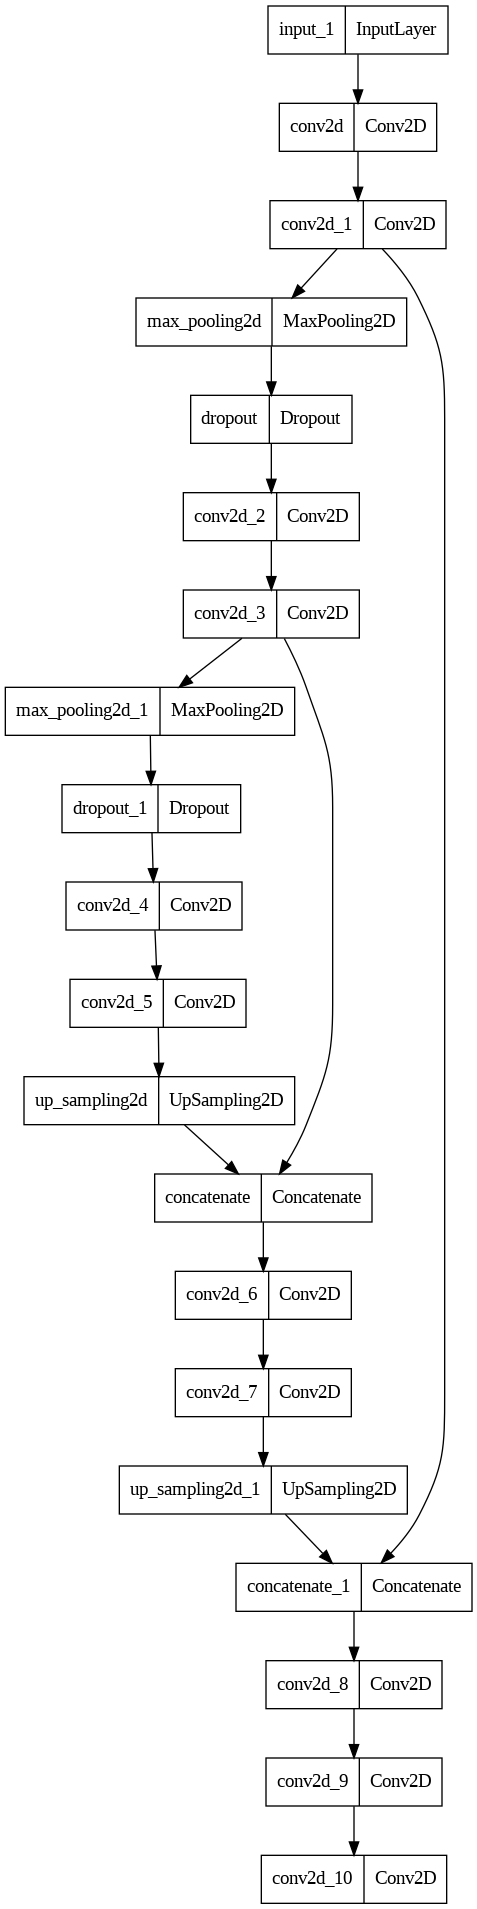

In [ ]:
# Visualize the model's architecture
from keras.utils import plot_model

plot_model(model, to_file='model.png')

### Specify Data Source, Hyperparameter and Generator Object

In [ ]:
# Specify Data Source, Hyperparameters, and Generator Object
tiff_path = '/content/drive/MyDrive/newdatsset'
n_epochs = 50
batch_size = 16


# Get list of TIFF file paths
file_paths = [os.path.join(tiff_path, f) for f in os.listdir(tiff_path) if f.endswith('.tif')]


# Shuffle and split data into training and validation sets
x_train, x_val = train_test_split(file_paths, test_size=0.2, random_state=42)


In [ ]:
# Create datasets
train_data = create_dataset(x_train, target_label=2, win_size=256, step=110, n_class=18)
val_data = create_dataset(x_val, target_label=2, win_size=256, step=110, n_class=18)

# Print the number of samples from each image
print("Number of samples from each image:")
print("Training data:")
for i, path in enumerate(x_train):
    n_samples = train_data[0][i].shape[0]
    print(f"{path}: {n_samples} samples")
print("Validation data:")
for i, path in enumerate(x_val):
    n_samples = val_data[0][i].shape[0]
    print(f"{path}: {n_samples} samples")


Number of samples from each image:
Training data:
/content/drive/MyDrive/newdatsset/Megara_cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/Mesorrahi_cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/KithnosA_Cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/CreteA_cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/Xios_cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/Velia_cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/Voras_cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/Tirnavos_cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/Lighurio_cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/Amfilochia_cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/Petroto_Cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/CreteB_cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/Anafi_cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/MetsitiaArta_cube.tif: 256 samples
/content/drive/MyDrive/newdatsset/Desfina_cube.tif: 2

In [ ]:
# Separate the input data and target labels
x_train = train_data[0]
y_train = train_data[1]
x_val = val_data[0]
y_val = val_data[1]

# Print the shapes of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (212, 256, 256, 24)
y_train shape: (212, 256, 256)
x_val shape: (128, 256, 256, 24)
y_val shape: (128, 256, 256)


x_train_normalized statistics:
Min: 0.0
Max: 1.0
Mean: 0.38518062
Std: 0.1803332


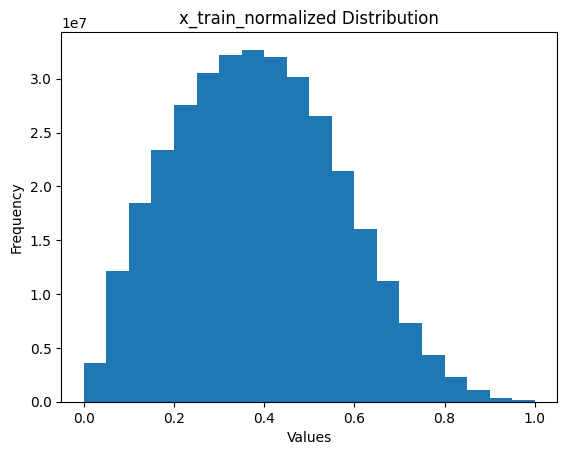

In [ ]:
# Calculate the mean value of your training data
data_mean = np.mean(x_train)


# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
x_train_normalized = scaler.fit_transform(x_train.reshape(-1, 24)).reshape(x_train.shape)
x_val_normalized = scaler.transform(x_val.reshape(-1, 24)).reshape(x_val.shape)

# Print the statistics of the normalized data
print("x_train_normalized statistics:")
print("Min:", np.min(x_train_normalized))
print("Max:", np.max(x_train_normalized))
print("Mean:", np.mean(x_train_normalized))
print("Std:", np.std(x_train_normalized))
# Plot histogram of x_train_normalized
plt.hist(x_train_normalized.flatten(), bins=20)
plt.title("x_train_normalized Distribution")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Reshape x_train_normalized and x_val_normalized to 2D
n_samples_train, n_rows_train, n_cols_train, n_channels_train = x_train_normalized.shape
n_samples_val, n_rows_val, n_cols_val, n_channels_val = x_val_normalized.shape
x_train_2D = x_train_normalized.reshape(n_samples_train, n_rows_train * n_cols_train * n_channels_train)
x_val_2D = x_val_normalized.reshape(n_samples_val, n_rows_val * n_cols_val * n_channels_val)

# Apply Min-Max scaling to normalize the data for training and validation sets separately
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_2D)
x_val_scaled = scaler.transform(x_val_2D)

# Reshape back to 4D
x_train_cleaned = x_train_scaled.reshape(n_samples_train, n_rows_train, n_cols_train, n_channels_train)
x_val_cleaned = x_val_scaled.reshape(n_samples_val, n_rows_val, n_cols_val, n_channels_val)

# Print the statistics of the cleaned data
print("x_train_cleaned statistics:")
print("Min:", np.min(x_train_cleaned))
print("Max:", np.max(x_train_cleaned))
print("Mean:", np.mean(x_train_cleaned))
print("Std:", np.std(x_train_cleaned))

x_train_cleaned statistics:
Min: 0.0
Max: 1.0000001
Mean: 0.42752123
Std: 0.21556845


In [ ]:
# Add channel dimension to target labels
train_labels_reshaped = np.expand_dims(train_data[1], axis=-1)
val_labels_reshaped = np.expand_dims(val_data[1], axis=-1)

print("train_data[0] shape:", train_data[0].shape)
print("train_labels_reshaped shape:", train_labels_reshaped.shape)
print("val_data[0] shape:", val_data[0].shape)
print("val_labels_reshaped shape:", val_labels_reshaped.shape)

train_data[0] shape: (212, 256, 256, 24)
train_labels_reshaped shape: (212, 256, 256, 1)
val_data[0] shape: (128, 256, 256, 24)
val_labels_reshaped shape: (128, 256, 256, 1)


In [ ]:
# Compute and print statistics
train_min = np.min(train_data[0])
train_max = np.max(train_data[0])
train_mean = np.mean(train_data[0])
val_min = np.min(val_data[0])
val_max = np.max(val_data[0])
val_mean = np.mean(val_data[0])

print("Train Data Statistics:")
print(f"Minimum value: {train_min}")
print(f"Maximum value: {train_max}")
print(f"Mean value: {train_mean}")
print("Validation Data Statistics:")
print(f"Minimum value: {val_min}")
print(f"Maximum value: {val_max}")
print(f"Mean value: {val_mean}")

Train Data Statistics:
Minimum value: 0.0
Maximum value: 1.0000004768371582
Mean value: 0.38518062233924866
Validation Data Statistics:
Minimum value: 0.0
Maximum value: 1.000000238418579
Mean value: 0.43448126316070557


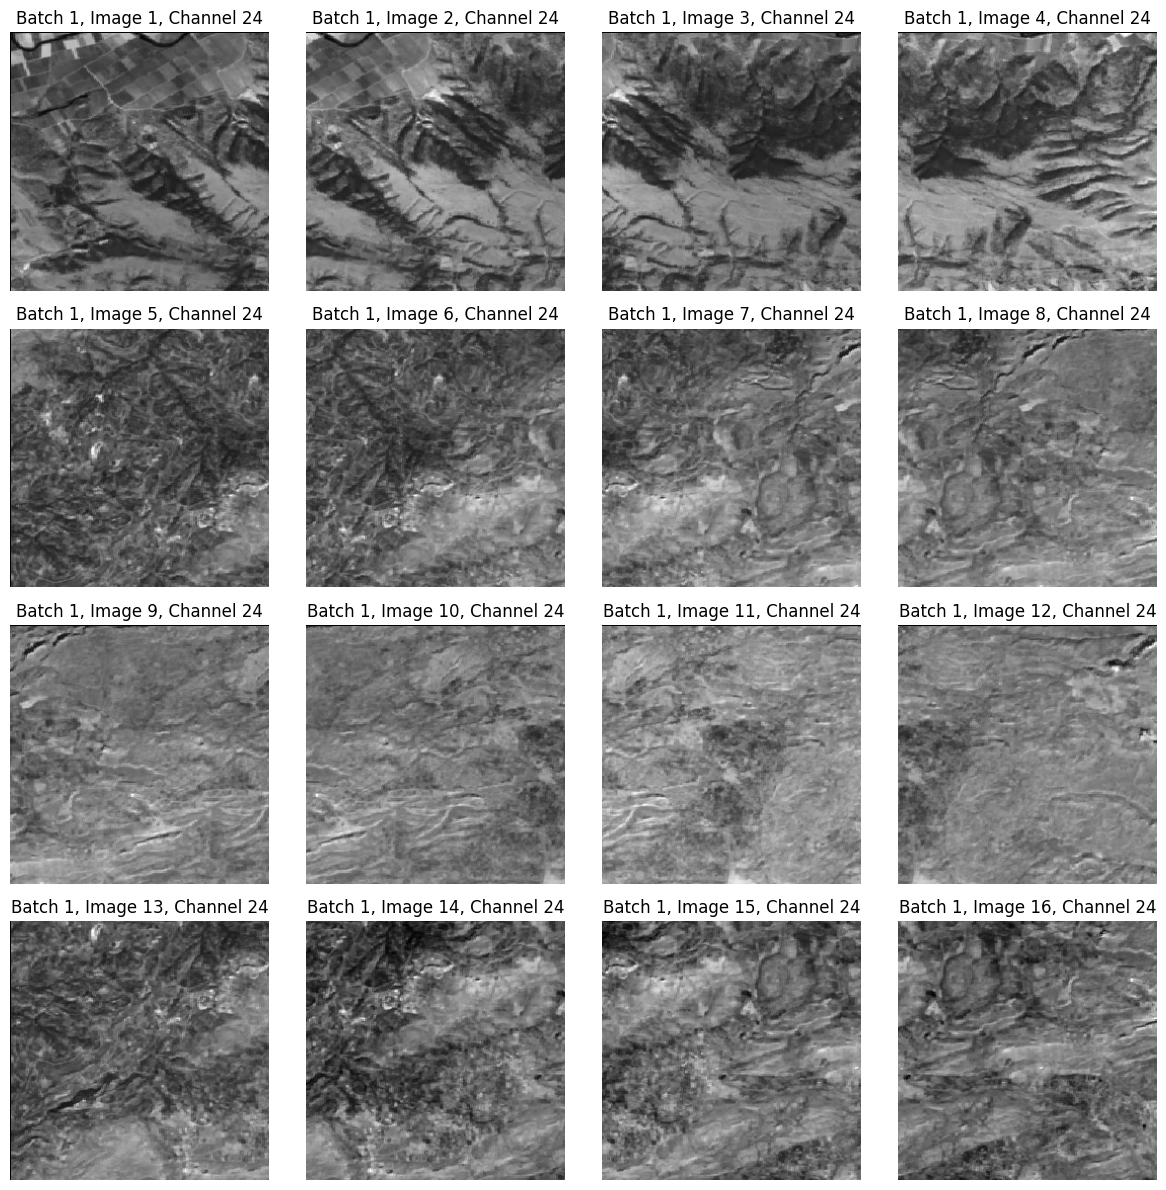

In [ ]:
n_batches = 1

for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    x_batch = x_train[start_idx:end_idx]
    y_batch = y_train[start_idx:end_idx]

    batch_size_actual = x_batch.shape[0]
    rows = (batch_size_actual + 3) // 4  # Compute the number of rows dynamically
    cols = min(batch_size_actual, 4)  # Limit the number of columns to 4

    fig, axs = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between subplots

    index = 0  # Track the index within the batch
    for row in range(rows):
        for col in range(cols):
            if index < batch_size_actual:
                for channel in range(x_batch.shape[-1]):
                    axs[row, col].imshow(x_batch[index, :, :, channel], cmap='gray')
                    axs[row, col].set_title(f"Batch {i+1}, Image {index+1}, Channel {channel+1}")
                    axs[row, col].axis('off')
                index += 1
            else:
                axs[row, col].axis('off')  # Hide blank subplots for extra positions

    plt.tight_layout()
    plt.show()


In [ ]:
# Define the model checkpoint callback
# This callback saves the model weights to a file when the validation loss improves.
checkpoint = ModelCheckpoint('best_model_weights.h5', save_best_only=True, save_weights_only=True,
                             monitor='val_loss', mode='min')

# Define early stopping callback
# This stops the training process if the validation loss hasn't improved for a specified number of epochs.
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1,
                               mode='auto', restore_best_weights=True)

# Define learning rate reduction callback
# This reduces the learning rate if the validation loss hasn't improved for a specified number of epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)




In [ ]:
# Manually prompt Python's garbage collector to free up memory.
gc.collect()


50

### Run the Training

In [ ]:

# Fit the model
#history = model.fit(x_train, train_labels_reshaped,
 #                   batch_size=batch_size,
   #                 validation_data=(x_val, val_labels_reshaped),
  #                  epochs=n_epochs,
    #                callbacks=[checkpoint, early_stopping, reduce_lr])
# Modify the model.fit() call to include the lr_schedule callback
# Fit the model

# Fit the model using the training data.
# This uses the cleaned and processed training data, the corresponding labels, and the specified batch size.
# Additionally, it uses the validation data for model validation during training.
# Callbacks are added to save the model's best weights, stop training early if necessary,
# and adjust the learning rate based on validation performance.
history = model.fit(x_train_cleaned, train_labels_reshaped,
                    batch_size=batch_size,
                    validation_data=(x_val_normalized, val_labels_reshaped),
                    epochs=n_epochs,
                    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/50
14/14 [==============================] - 98s 3s/step - loss: 0.9826 - accuracy: 0.4820 - val_loss: 0.6665 - val_accuracy: 0.6441 - lr: 1.0000e-04
Epoch 2/50
14/14 [==============================] - 30s 2s/step - loss: 0.6838 - accuracy: 0.5408 - val_loss: 0.6655 - val_accuracy: 0.6269 - lr: 1.0000e-04
Epoch 3/50
14/14 [==============================] - 30s 2s/step - loss: 0.6378 - accuracy: 0.6539 - val_loss: 0.6540 - val_accuracy: 0.6046 - lr: 1.0000e-04
Epoch 4/50
14/14 [==============================] - 30s 2s/step - loss: 0.5942 - accuracy: 0.6919 - val_loss: 0.6544 - val_accuracy: 0.6124 - lr: 1.0000e-04
Epoch 5/50
14/14 [==============================] - 30s 2s/step - loss: 0.5864 - accuracy: 0.6916 - val_loss: 0.6406 - val_accuracy: 0.6339 - lr: 1.0000e-04
Epoch 6/50
14/14 [==============================] - 30s 2s/step - loss: 0.5592 - accuracy: 0.7171 - val_loss: 0.6545 - val_accuracy: 0.6298 - lr: 1.0000e-04
Epoch 7/50
14/14 [==============================] - 30s 2s

Training loss: 0.38243725895881653
Training accuracy: 0.8252546191215515
Validation loss: 0.6970410943031311
Validation accuracy: 0.6439229249954224


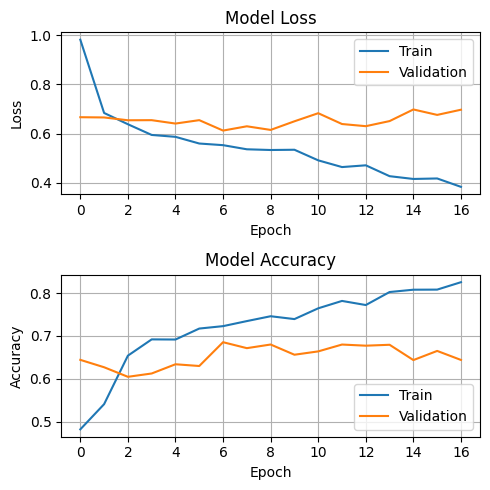

In [ ]:
# Print the training and validation loss and accuracy
print("Training loss:", history.history['loss'][-1])
print("Training accuracy:", history.history['accuracy'][-1])
print("Validation loss:", history.history['val_loss'][-1])
print("Validation accuracy:", history.history['val_accuracy'][-1])

fig, axs = plt.subplots(2, 1, figsize=(5, 5))

# Plot the training and validation loss curves
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Validation'], loc='upper right')
axs[0].grid(True)

# Plot the training and validation accuracy curves
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Model Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Validation'], loc='lower right')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:

# Save the trained model to a file
model.save('/content/drive/MyDrive/trained_model.h5')


### Prediction Test with Sample Image from Dataset

In [ ]:

def prediction_test(model, image_path, target_label, win_size, step, label_channel, n_class):
    # Load and preprocess the image
    x_test, y_test = process_image(image_path, target_label, win_size, step, label_channel, n_class)

    if x_test is None or y_test is None:
        print("Error: Image processing failed.")
        return

    # Perform prediction
    y_pred = model.predict(x_test)

    # Convert predictions to binary labels
    y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test.flatten(), y_pred_binary.flatten())
    precision = precision_score(y_test.flatten(), y_pred_binary.flatten())
    recall = recall_score(y_test.flatten(), y_pred_binary.flatten())

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)

    # Reshape predicted labels to match the input shape
    y_pred_binary = y_pred_binary.reshape(y_test.shape)

    # Plot ground truth and predicted images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(y_test[0].squeeze(), cmap='plasma')
    axes[0].set_title("Ground Truth")
    axes[0].axis('off')

    # Check if predicted image is grayscale or RGB
    if y_pred_binary.shape[-1] == 1:
        axes[1].imshow(y_pred_binary[0].squeeze(), cmap='gray')
    else:
        axes[1].imshow(y_pred_binary[0].squeeze())

    axes[1].set_title("Predicted")
    axes[1].axis('off')
    plt.show()




### Show Prediciton Result

1/1 [==============================] - 0s 183ms/step
Accuracy: 0.5870814323425293
Precision: 0.9653919625445163
Recall: 0.3632703379421239


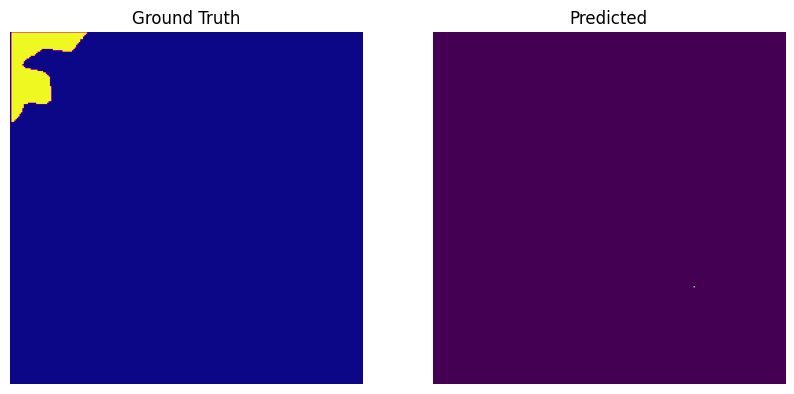

In [ ]:
# Example of calling prediction_test function


# Example of calling prediction_test function
image_path = '/content/drive/MyDrive/newdatsset/CreteA_cube.tif'  # Path to the image file
target_label = 2  # Index of the target label to extract
win_size = 256  # Size of the sliding window
step = 110  # Step size for sliding the window
label_channel = 24  # Channel index containing the label information
n_class = 18  # Number of classes in the label data

# Call the prediction_test function
prediction_test(model, image_path, target_label, win_size, step, label_channel, n_class)




In [ ]:


# Define the hot_encode_label function
def hot_encode_label(tiff_path, n_class, label_channel=25):
    # Hot encode the label from 1 layer array to 18 layer array and return array with 1 selected layer
    # (Assuming your label data has 18 classes and the label information is in the 25th channel)
    tiff_file = rasterio.open(tiff_path)
    mask = tiff_file.read(label_channel)
    mask[mask == -999] = 16
    mask[mask == -100] = 17
    encoded = np.zeros((mask.shape[0], mask.shape[1], n_class))
    for i in range(n_class):
        encoded[:, :, i] = mask == i

    return encoded

# Define the prediction_test function
def prediction_test(model, image_path, target_label, win_size, step, label_channel, n_class):
    # Load and preprocess the image
    x_test, y_test = process_image(image_path, target_label, win_size, step, label_channel, n_class)

    if x_test is None or y_test is None:
        print("Error: Image processing failed.")
        return

    # Perform prediction
    y_pred = model.predict(x_test)

    # Convert predictions to binary labels
    y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test.flatten(), y_pred_binary.flatten())
    precision = precision_score(y_test.flatten(), y_pred_binary.flatten())
    recall = recall_score(y_test.flatten(), y_pred_binary.flatten())

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)

    # Compute the confusion matrix
    conf_mat = confusion_matrix(y_test.flatten(), y_pred_binary.flatten())

    # Plot the confusion matrix
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Reshape predicted labels to match the input shape
    y_pred_binary = y_pred_binary.reshape(y_test.shape)

    # Plot ground truth and predicted images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the ground truth
    labels = hot_encode_label(image_path, n_class=18)
    ground_truth = labels[:, :, target_label]
    _, ground_truth = cv.threshold(ground_truth, 0.5, 1, cv.THRESH_BINARY)
    axes[0].imshow(ground_truth, cmap='cividis')
    axes[0].set_title("Ground Truth")
    axes[0].axis('off')

    # Display the predicted image
    axes[1].imshow(y_pred_binary[29], cmap='cividis')
    axes[1].set_title("Predicted")
    axes[1].axis('off')
    plt.show()




1/1 [==============================] - 0s 281ms/step
Accuracy: 0.5870814323425293
Precision: 0.9653919625445163
Recall: 0.3632703379421239


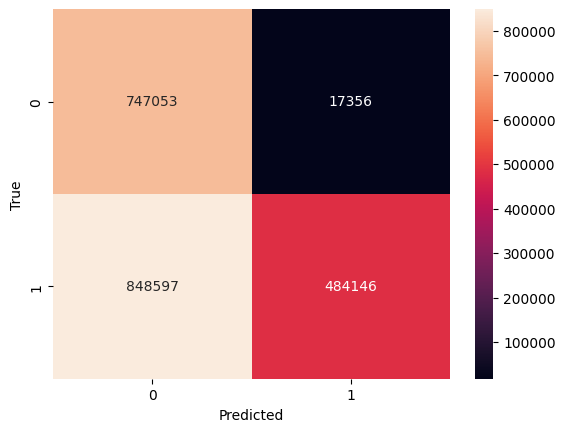

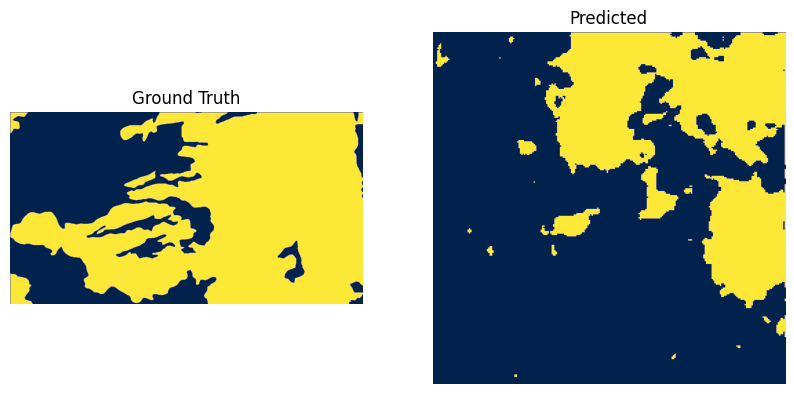

In [ ]:

# Load the trained model
model = load_model('/content/drive/MyDrive/trained_model.h5')

# Example of calling prediction_test function
image_path = '/content/drive/MyDrive/newdatsset/CreteA_cube.tif'  # Path to the image file
target_label = 2  # Index of the target label to extract
win_size = 256  # Size of the sliding window
step = 110  # Step size for sliding the window
label_channel = 24  # Channel index containing the label information (25th channel based on your explanation)
n_class = 18  # Number of classes in the label data

# Call the prediction_test function
prediction_test(model, image_path, target_label, win_size, step, label_channel, n_class)


### Visualize Ground Truth
Visualize the ground truth (specific mask layer) from a file

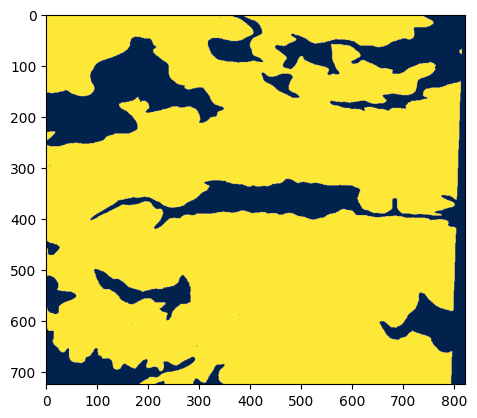

In [ ]:
# Load test image
test_img_path = '/content/drive/MyDrive/newdatsset/AgiosGeorgios_Cube.tif'

# Label layer to visualize
label_id = 2

def hot_encode_label(tiff_path, n_class, label_channel=25):
  # Hot encode the label from 1 layer array to 18 layer array and return array with 1 selected layer
  tiff_file = rasterio.open(tiff_path)
  mask = tiff_file.read(25)
  mask[mask==-999] = 16
  mask[mask==-100] = 17
  encoded = np.zeros((mask.shape[0], mask.shape[1], 18))
  for i in range(n_class):
    encoded[:,:,i] = mask==i

  return encoded

labels = hot_encode_label (test_img_path, n_class = 18)
label = labels[:,:,label_id]

# Threshold it to produce binary image
_, label = cv.threshold(label, 0.5, 1, cv.THRESH_BINARY)

plt.imshow(label, cmap = 'cividis')
